# Metadata :
**Report: Anomaly Detection**

- `Author` : Taisir Boukrouba
- `ID` : 22084758
- `Module` : Data Mining & Discovery
- `Group` : 48
- `Subject` : 08
- `Problem` : Clustering Vs. Anomaly
- `Data` : [UCI Rent Data](https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified)


> **NOTE** : If data took to much to load disconnect and delete runtime , and re-run again ( the data is big and we took a sample from it later )



# Initialisaition





In [1]:
# this is important to be able to load our data using its API
!pip install ucimlrepo

In [2]:
# defining our libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import warnings

warnings.filterwarnings("ignore")

In [3]:
def outliers_analysis(df, col_name):
    """
    Analyzes outliers in a DataFrame column.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        col_name (str): The name of the column to analyze for outliers.

    Returns:
        tuple: A tuple containing the lower and upper bounds of the outliers.

    This function calculates the lower and upper bounds for outliers using the interquartile range (IQR) method.
    It then identifies outliers in the specified column based on these bounds and prints the count of outliers.
    """

    col = df[col_name]

    # Calculate IQR
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1

    # Define outlier thresholds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Count outliers
    outliers = col[(col < lower_bound) | (col > upper_bound)]
    num_outliers = len(outliers)
    print(f"There are approximately {num_outliers} outliers in {col_name}")

    return lower_bound, upper_bound


In [4]:
def stratified_sampling(df, strata_col, sample_size):
    """
    Performs stratified sampling on a DataFrame based on a specified strata column.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        strata_col (str): The name of the column to be used as strata.
        sample_size (float): The desired size of the sample as a fraction of the total data.

    Returns:
        DataFrame: A DataFrame containing the stratified sample.

    This function divides the DataFrame into groups based on the values in the specified strata column.
    It then samples from each group proportionally to its size in the original data, ensuring representation
    of each stratum in the final sample.
    """

    # Grouping the DataFrame by the specified strata column
    groups = df.groupby(strata_col)

    # Initializing an empty DataFrame to store the sample
    sample = pd.DataFrame()

    # Iterating over each group
    for _, group in groups:
        # Sampling from each group using the specified sample size fraction
        stratum_sample = group.sample(frac=sample_size, replace=False, random_state=7)

        # Concatenating the sampled data from each stratum to the sample DataFrame
        sample = pd.concat([sample, stratum_sample], ignore_index=True)

    return sample

In [5]:
def categorize_rent(rent, q1, q3):
    """
    Categorizes rent into affordability levels based on quartile ranges.

    Parameters:
        rent (float): The rent value to be categorized.
        q1 (float): The first quartile value.
        q3 (float): The third quartile value.

    Returns:
        str: A string indicating the category of rent (Expensive, Moderate, or Affordable).

    This function categorizes rent into three affordability levels: Expensive, Moderate, and Affordable,
    based on quartile ranges. Rent above the third quartile is categorized as Expensive, rent within
    the interquartile range (between the first and third quartile) is categorized as Moderate, and
    rent below the first quartile is categorized as Affordable.
    """

    if rent > q3:
        return "Expensive"
    elif rent >= q1 and rent <= q3:
        return "Moderate"
    else:
        return "Affordable"


## Loading Data :

In [6]:
# fetch dataset
apartment_for_rent_classified = fetch_ucirepo(id=555)

# data (as pandas dataframes)
rent_df = apartment_for_rent_classified.data.features

In [7]:
#viewing first 5 rows of the dataframe
rent_df.head(5)

,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1,1,USD,No,Thumbnail,Cats,...,2195,Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1.577360e+09
1,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3,USD,No,Thumbnail,"Cats,Dogs",...,1250,Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1.577360e+09
2,housing/rent/apartment,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2,3,USD,No,Thumbnail,NaN,...,1395,Monthly,1650,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1.577360e+09
3,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1,2,USD,No,Thumbnail,"Cats,Dogs",...,1600,Monthly,820,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1.577360e+09
4,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1,1,USD,No,Thumbnail,"Cats,Dogs",...,975,Monthly,624,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1.577360e+09


**IMPORTANT :** Please note that we dropped 3 meta-features which are features that has information about the dataset itself such as *time* (when data was created) , *source* (the source of each data point ) , *price\_display* (the same price column but in integer format) upon loading our data as a pandas dataframe.

In [8]:
# deleteing meta-information columns
rent_df = rent_df.drop(columns=["time","source","price_display"])

In [9]:
# verifying our data
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      99826 non-null  object 
 1   title         99826 non-null  object 
 2   body          99826 non-null  object 
 3   amenities     83749 non-null  object 
 4   bathrooms     99760 non-null  object 
 5   bedrooms      99699 non-null  object 
 6   currency      99822 non-null  object 
 7   fee           99823 non-null  object 
 8   has_photo     99823 non-null  object 
 9   pets_allowed  39192 non-null  object 
 10  price         99821 non-null  float64
 11  price_type    99823 non-null  object 
 12  square_feet   99823 non-null  object 
 13  address       7946 non-null   object 
 14  cityname      99521 non-null  object 
 15  state         99521 non-null  object 
 16  latitude      99797 non-null  float64
 17  longitude     99795 non-null  float64
dtypes: float64(3), object(15)


# Preprocessing

## I -  Data Cleaning :
This is the part where we clean our data from all missing values and other problems in the following pipeline :  


1.   **Handling Missing Values**
2.   **Handling Duplicates**
3.   **Dealing with Outliers**



### Handling Missing Values

In [10]:
# getting missing data percentage
missing_perc = (rent_df.isnull().sum()/rent_df.shape[0])*100

In [11]:
# printing missing data percentage
missing_perc

category         0.000000
title            0.000000
body             0.000000
amenities       16.105023
bathrooms        0.066115
bedrooms         0.127221
currency         0.004007
fee              0.003005
has_photo        0.003005
pets_allowed    60.739687
price            0.005009
price_type       0.003005
square_feet      0.003005
address         92.040150
cityname         0.305532
state            0.305532
latitude         0.029051
longitude        0.031054
dtype: float64

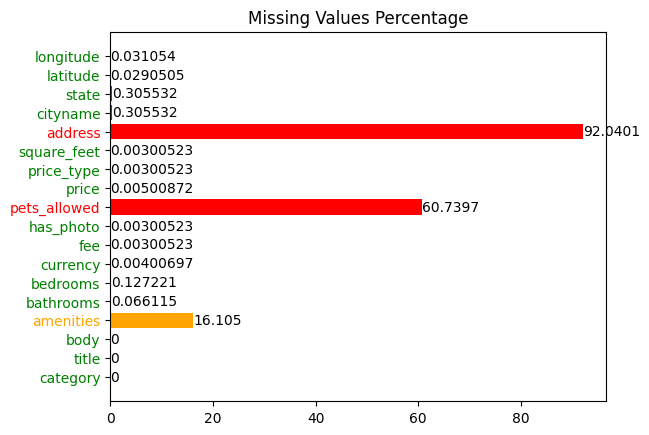

In [12]:
# creating color ranges for missing data
color_ranges = [(0, 10, 'green'), (10, 50, 'orange'), (50, 100, 'red')]

# Assign colors based on ranges and create final color list
final_colors = []
for value in missing_perc.values:
  for min_value, max_value, color in color_ranges:
    if min_value <= value <= max_value:
      final_colors.append(color)
      break

fig, ax = plt.subplots()
bars = ax.barh(missing_perc.index, missing_perc.values,color=final_colors)
ax.bar_label(bars)
plt.title("Missing Values Percentage");

# coloring the y-labels for better context
y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
  label.set_color(final_colors[i])

In [13]:
# dropping columns with high missing values percentage
rent_df.drop(columns=["address","pets_allowed"],inplace=True)

In [14]:
# dropping the rest of the missing rows
rent_df = rent_df.dropna()

In [15]:
# investigating the new data size
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83464 entries, 21 to 99825
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     83464 non-null  object 
 1   title        83464 non-null  object 
 2   body         83464 non-null  object 
 3   amenities    83464 non-null  object 
 4   bathrooms    83464 non-null  object 
 5   bedrooms     83464 non-null  object 
 6   currency     83464 non-null  object 
 7   fee          83464 non-null  object 
 8   has_photo    83464 non-null  object 
 9   price        83464 non-null  float64
 10  price_type   83464 non-null  object 
 11  square_feet  83464 non-null  object 
 12  cityname     83464 non-null  object 
 13  state        83464 non-null  object 
 14  latitude     83464 non-null  float64
 15  longitude    83464 non-null  float64
dtypes: float64(3), object(13)
memory usage: 10.8+ MB


### Handling Duplicates :

In [16]:
# removing duplicates from our data
duplicate_counts = rent_df.duplicated(keep='first').sum() - 1

print(f"we have {duplicate_counts} duplicate rows")

rent_df = rent_df.drop_duplicates()

we have 73 duplicate rows


In [17]:
# investigating the first 5 rows
rent_df.head(5)

,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,price,price_type,square_feet,cityname,state,latitude,longitude
21,housing/rent/apartment,One BR 7011 W PARMER LN,"This unit is located at 7011 W PARMER LN, Aust...","Fireplace,Gym,Parking,Pool,Storage,Wood Floors",1,1,USD,No,Thumbnail,1060.0,Monthly,650,Austin,TX,30.3054,-97.7497
22,housing/rent/apartment,One BR 2800 SUNRISE RD,"This unit is located at 2800 SUNRISE RD, Round...","Gated,Pool",1,1,USD,No,Thumbnail,1003.0,Monthly,797,Round Rock,TX,30.5118,-97.6873
23,housing/rent/apartment,One BR 12330 METRIC BLVD.,"This unit is located at 12330 METRIC BLVD., Au...","Dishwasher,Parking,Pool",1,1,USD,No,Thumbnail,837.0,Monthly,444,Austin,TX,30.3054,-97.7497
24,housing/rent/apartment,One BR 8021 FM 620 NORTH,"This unit is located at 8021 FM 620 NORTH, Aus...","Dishwasher,Parking,Pool",1,1,USD,No,Thumbnail,1020.0,Monthly,692,Austin,TX,30.3054,-97.7497
25,housing/rent/apartment,One BR 11500 JOLLYVILLE RD.,"This unit is located at 11500 JOLLYVILLE RD., ...","Gym,Pool",1,1,USD,No,Thumbnail,985.0,Monthly,693,Austin,TX,30.3054,-97.7497


### Dealing With Outliers :

In [18]:
# getting the float datatype columns
float_dtypes = rent_df.select_dtypes(include=[np.float64])

In [19]:
# priting them
float_dtypes

,price,latitude,longitude
21,1060.0,30.3054,-97.7497
22,1003.0,30.5118,-97.6873
23,837.0,30.3054,-97.7497
24,1020.0,30.3054,-97.7497
25,985.0,30.3054,-97.7497
...,...,...,...
99821,780.0,29.6151,-95.1998
99822,813.0,30.2254,-81.7579
99823,1325.0,32.7379,-117.0914
99824,931.0,35.4158,-80.8451


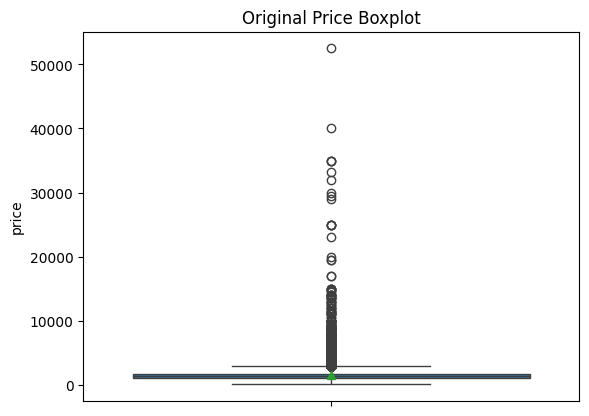

In [20]:
# investigating "price" (the others don't have many outliers)
sns.boxplot(data=rent_df,y="price",showmeans=True)
plt.title('Original Price Boxplot');

In [21]:
# getting the lower and upper bound to use in cutting our outliers
price_lb , price_ub = outliers_analysis(rent_df,"price")
lat_lb , lat_ub = outliers_analysis(rent_df,"latitude")
long_lb , long_ub = outliers_analysis(rent_df,"longitude")

There are approximately 3929 outliers in price
There are approximately 61 outliers in latitude
There are approximately 58 outliers in longitude


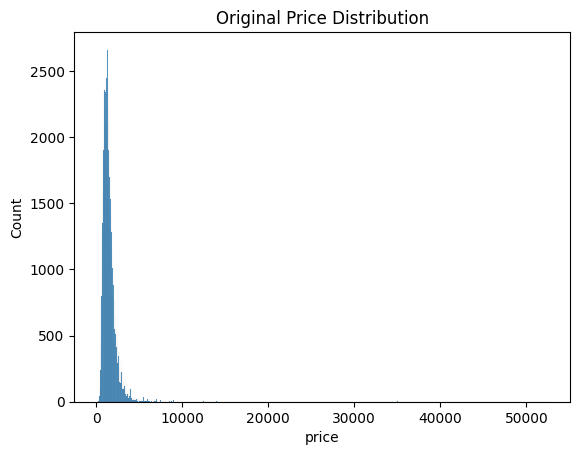

In [22]:
# plotting original price distribution
sns.histplot(data=rent_df,x="price");
plt.title('Original Price Distribution');

In [23]:
# winsorizing using IQR bounds
rent_df["price"] = rent_df["price"].clip(lower=price_lb, upper=price_ub);

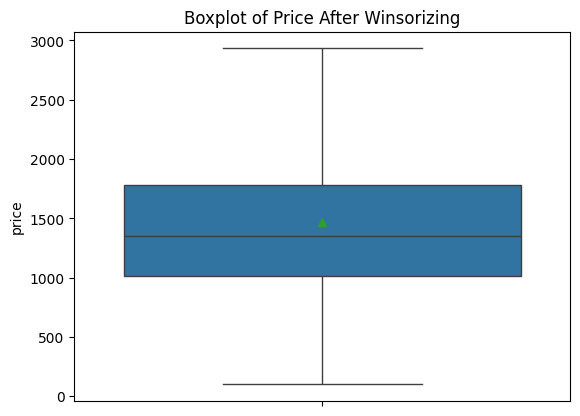

In [24]:
# plotting the price after winsorizing (cutting)
sns.boxplot(data=rent_df,y="price",showmeans=True)
plt.title('Boxplot of Price After Winsorizing');

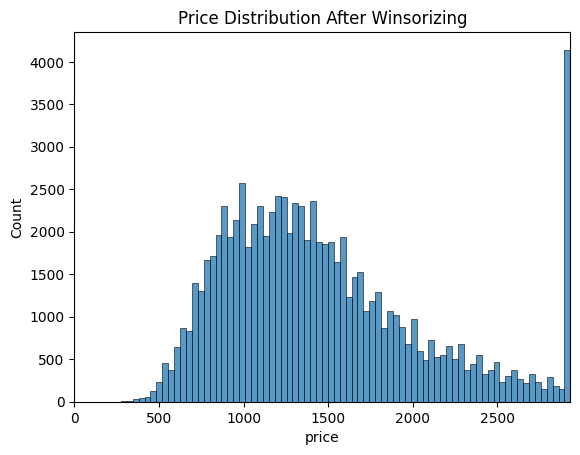

In [25]:
# the last price category might seem like a problem but it is normal and our data is guassian now
sns.histplot(data=rent_df,x="price");
plt.title('Price Distribution After Winsorizing')
plt.xlim(0,max(rent_df["price"]));

## II - Data Formatting :
This step is the process of arranging data in a consistent, computer-readable way , which we have done in the following step :  


1.   **Formatting Values**: Change Bad Input and Unacessary Categories
2.   **Formatting Datatype** : Convert Features to its correct type
3.  **Cardinality Check** : Check data uniquness through high/low cardinality
4. **Encoding Data**: Change Categorical data into numerical using Label Encoder



### Formatting Values :

In [26]:
# investigating data
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83390 entries, 21 to 99825
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     83390 non-null  object 
 1   title        83390 non-null  object 
 2   body         83390 non-null  object 
 3   amenities    83390 non-null  object 
 4   bathrooms    83390 non-null  object 
 5   bedrooms     83390 non-null  object 
 6   currency     83390 non-null  object 
 7   fee          83390 non-null  object 
 8   has_photo    83390 non-null  object 
 9   price        83390 non-null  float64
 10  price_type   83390 non-null  object 
 11  square_feet  83390 non-null  object 
 12  cityname     83390 non-null  object 
 13  state        83390 non-null  object 
 14  latitude     83390 non-null  float64
 15  longitude    83390 non-null  float64
dtypes: float64(3), object(13)
memory usage: 10.8+ MB


In [27]:
# investigating "has_photo" categories
rent_df.has_photo.value_counts()

has_photo
Yes          48494
Thumbnail    28001
No            6895
Name: count, dtype: int64

In [28]:
# assigning the values
rent_df.has_photo[rent_df.has_photo == "Thumbnail"] = "Yes"

In [29]:
# verifying "has_photo" categories
rent_df.has_photo.value_counts()

has_photo
Yes    76495
No      6895
Name: count, dtype: int64

### Formatting Datatype :

In [30]:
# investigating data (there is some features which has the wrong datatype)
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83390 entries, 21 to 99825
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     83390 non-null  object 
 1   title        83390 non-null  object 
 2   body         83390 non-null  object 
 3   amenities    83390 non-null  object 
 4   bathrooms    83390 non-null  object 
 5   bedrooms     83390 non-null  object 
 6   currency     83390 non-null  object 
 7   fee          83390 non-null  object 
 8   has_photo    83390 non-null  object 
 9   price        83390 non-null  float64
 10  price_type   83390 non-null  object 
 11  square_feet  83390 non-null  object 
 12  cityname     83390 non-null  object 
 13  state        83390 non-null  object 
 14  latitude     83390 non-null  float64
 15  longitude    83390 non-null  float64
dtypes: float64(3), object(13)
memory usage: 10.8+ MB


In [31]:
# investigating "square_feet" values datatype
rent_df.square_feet.value_counts()

square_feet
1000    882
900     751
800     750
700     691
1100    682
       ... 
2818      1
2416      1
2665      1
1935      1
2252      1
Name: count, Length: 3719, dtype: int64

In [32]:
# investigating "bedrooms" values datatype
rent_df.bedrooms.value_counts()

bedrooms
2      38741
1      33302
3       8390
4        925
2.0      639
1.0      596
0        434
5        168
3.0      131
6         29
4.0       23
0.0        4
5.0        3
8          2
7          2
9          1
Name: count, dtype: int64

In [33]:
# investigating "bedrooms" values datatype
rent_df.bathrooms.value_counts()

bathrooms
1      46200
2      30940
1.5     2592
2.5     1418
1.0      752
3        632
2.0      553
3.5       91
4         71
2.5       35
1.5       35
4.5       20
5         16
3.0       13
6          7
4.0        4
3.5        3
5.5        3
9          1
7          1
8          1
7.5        1
4.5        1
Name: count, dtype: int64

In [34]:
# changing the features into their true datatype (float)
columns = ["bedrooms","bathrooms","square_feet"]
for col in columns :
  rent_df[col] = rent_df[col].astype(float)
  rent_df[col] = round(rent_df[col],0)

In [35]:
# verifying "bedrooms" values datatype
rent_df.bedrooms.value_counts()

bedrooms
2.0    39380
1.0    33898
3.0     8521
4.0      948
0.0      438
5.0      171
6.0       29
8.0        2
7.0        2
9.0        1
Name: count, dtype: int64

In [36]:
# verifying the dataframe values datatype
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83390 entries, 21 to 99825
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     83390 non-null  object 
 1   title        83390 non-null  object 
 2   body         83390 non-null  object 
 3   amenities    83390 non-null  object 
 4   bathrooms    83390 non-null  float64
 5   bedrooms     83390 non-null  float64
 6   currency     83390 non-null  object 
 7   fee          83390 non-null  object 
 8   has_photo    83390 non-null  object 
 9   price        83390 non-null  float64
 10  price_type   83390 non-null  object 
 11  square_feet  83390 non-null  float64
 12  cityname     83390 non-null  object 
 13  state        83390 non-null  object 
 14  latitude     83390 non-null  float64
 15  longitude    83390 non-null  float64
dtypes: float64(6), object(10)
memory usage: 10.8+ MB


### Cardinality Check :

In [37]:
# getting the rent data uniqueness percentage (unique values / total values)
rent_card = round((rent_df.nunique()/rent_df.shape[0])*100,2)

In [38]:
rent_card

category        0.01
title          58.70
body           94.67
amenities      11.76
bathrooms       0.01
bedrooms        0.01
currency        0.00
fee             0.00
has_photo       0.00
price           2.96
price_type      0.00
square_feet     2.68
cityname        3.21
state           0.06
latitude        7.79
longitude       7.85
dtype: float64

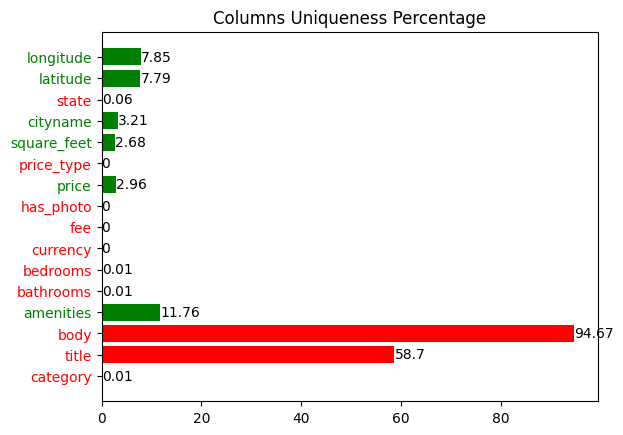

In [39]:
# plotting the uniquness percentage

# defining the color ranges
color_ranges = [(0, 1, 'red'), (1, 20, 'green'), (20, 100, 'red')]

# Assigning colors based on ranges and create final color list
final_colors = []
for value in rent_card.values:
  for min_value, max_value, color in color_ranges:
    if min_value <= value <= max_value:
      final_colors.append(color)
      break

fig, ax = plt.subplots()
bars = ax.barh(rent_card.index, rent_card.values,color=final_colors)
ax.bar_label(bars)
plt.title("Columns Uniqueness Percentage");


# coloring the y-labels for better context
y_labels = plt.gca().get_yticklabels()
for i, label in enumerate(y_labels):
  label.set_color(final_colors[i])

In [40]:
# verifying "currency" categories
rent_df.currency.value_counts()

currency
USD    83390
Name: count, dtype: int64

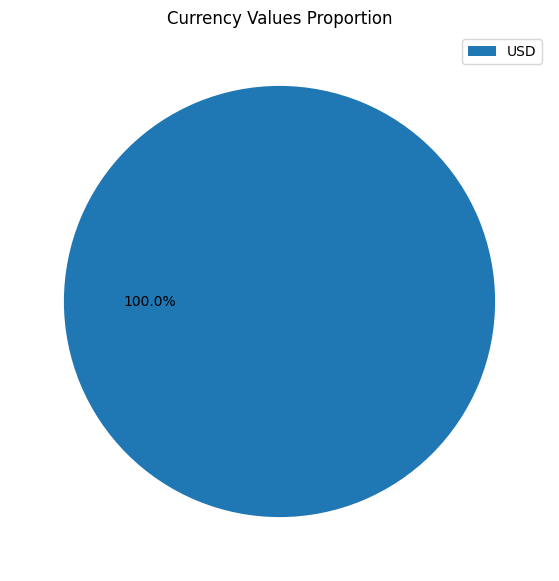

In [41]:
# plotting "currency" categories
plt.figure(figsize=(15,7))
plt.pie(rent_df["currency"].value_counts(),autopct='%1.1f%%')
plt.legend(["USD"])
plt.title("Currency Values Proportion");

In [42]:
# verifying "price_type" categories
rent_df.price_type.value_counts()

price_type
Monthly    83387
Weekly         3
Name: count, dtype: int64

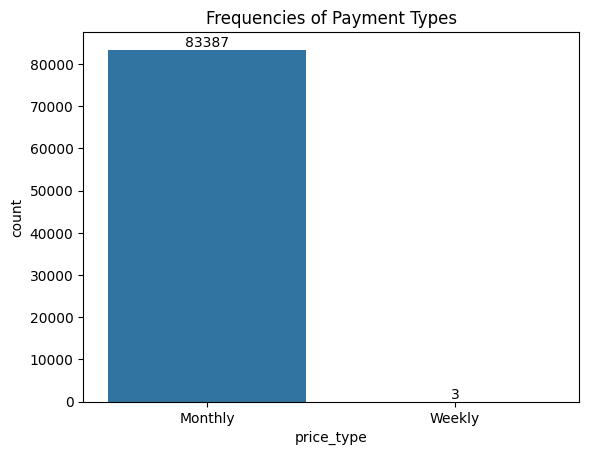

In [43]:
# plotting "price_type" categories
ax = sns.countplot(data=rent_df,x="price_type")
ax.bar_label(ax.containers[0])
plt.title("Frequencies of Payment Types");

In [44]:
# verifying "body" categories
rent_df.body.value_counts()[:5]

body
When searching for a pet-friendly One-, Two- and 3 Beds apartment homes in Randallstown, look no further than Northwest Crossing. Northwest Crossing's convenient suburban. and Liberty provides you with immediate access to shopping, entertainment, transportation and is directly across from Northwest Hospital. Commuters enjoy easy access to Baltimore's Inner, Baltimore Washington International Airport BWI, Owings Mills, Pikesville, and Catonsville. The Crossing enjoy the comforts of an apartment they are truly proud to with wall-to-wall carpeting, fully-equipped kitchens with dishwashers, over-sized closets and expansive balconies. Outside your home, Northwest Crossing boasts a fitness facilities, basketball and professionally landscaped grounds with picnic areas. Take pleasure in knowing that our professional management team is here to assist you with any need great or small. We are excited to meet you and welcome you home!                                                           

In [45]:
# dropping these columns (they have low cardinality)
rent_df = rent_df.drop(columns=["currency","price_type","body","title"])

### One Hot Encoding :

In [46]:
# we could do one hot encoding to aminitiest (takes too much time and processing power that we cannot afford with about 88K rows)
rent_df.amenities.value_counts()

amenities
Parking                                                                                                                    6162
Parking,Storage                                                                                                            2115
Gym,Pool                                                                                                                   1873
Pool                                                                                                                       1479
Gym,Parking,Pool                                                                                                           1183
                                                                                                                           ... 
AC,Cable or Satellite,Dishwasher,Fireplace,Garbage Disposal,Patio/Deck,Refrigerator,Tennis,Washer Dryer                       1
Gated,Parking,Pool,Washer Dryer,Wood Floors                                                   

In [47]:
rent_df = rent_df.drop(columns=["amenities"])

In [48]:
rent_df.category.value_counts()

category
housing/rent/apartment            83332
housing/rent/commercial/retail       42
housing/rent                          6
housing/rent/home                     4
housing/rent/condo                    3
housing/rent/short_term               2
housing/rent/other                    1
Name: count, dtype: int64

In [49]:
rent_df.category = rent_df.category.str.split("/",expand=True)[2]

In [50]:
rent_df.category.value_counts()

category
apartment     83332
commercial       42
home              4
condo             3
short_term        2
other             1
Name: count, dtype: int64

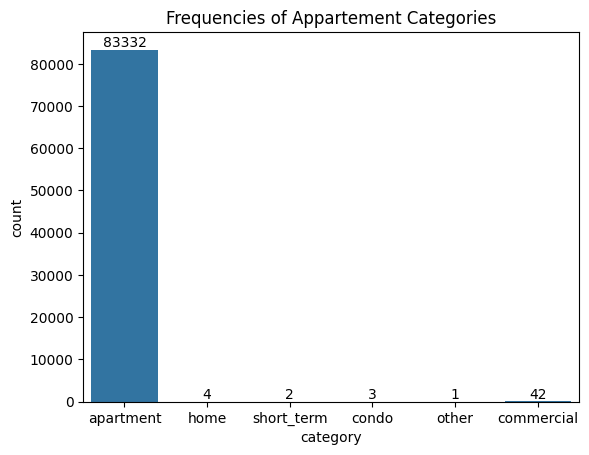

In [51]:
ax = sns.countplot(data=rent_df,x="category")
ax.bar_label(ax.containers[0])
plt.title("Frequencies of Appartement Categories");

In [52]:
rent_df = rent_df[rent_df.category == "apartment"]

In [53]:
rent_df=rent_df.drop(columns=["category"])

### Label Encoder

In [54]:
# Converting our data from categorical into numerical to be inputted into the model
object_cols = rent_df.select_dtypes(include="object")

le = LabelEncoder()

for col in object_cols :
  # Fitting the encoder to the categories (learn the mapping)
  rent_df[col] = le.fit_transform(rent_df[col])

## III - Resizing Data :
In this step we use the price and we convert it into categorical variable to use it for smapling our data ( **stratified random sampling** ) where we are taking 1% of our data

### Categorising Target Variable :

In [55]:
# checking the data
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83332 entries, 21 to 99825
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    83332 non-null  float64
 1   bedrooms     83332 non-null  float64
 2   fee          83332 non-null  int64  
 3   has_photo    83332 non-null  int64  
 4   price        83332 non-null  float64
 5   square_feet  83332 non-null  float64
 6   cityname     83332 non-null  int64  
 7   state        83332 non-null  int64  
 8   latitude     83332 non-null  float64
 9   longitude    83332 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.0 MB


In [56]:
# getting some summary stats
rent_df.price.describe()

count    83332.000000
mean      1467.289745
std        601.051265
min        100.000000
25%       1011.000000
50%       1349.000000
75%       1780.000000
max       2932.000000
Name: price, dtype: float64

In [57]:
# saving the data (will use it later)
old_data = rent_df.copy()

In [58]:
# calculating quartiles to create a target variable from price (categorization)
q1 = np.percentile(rent_df["price"], 25)
q2 = np.percentile(rent_df["price"], 50)
q3 = np.percentile(rent_df["price"], 75)

In [59]:
# categorizing rent
rent_df["price_cat"] = rent_df["price"].apply(lambda x: categorize_rent(x, q1, q3))

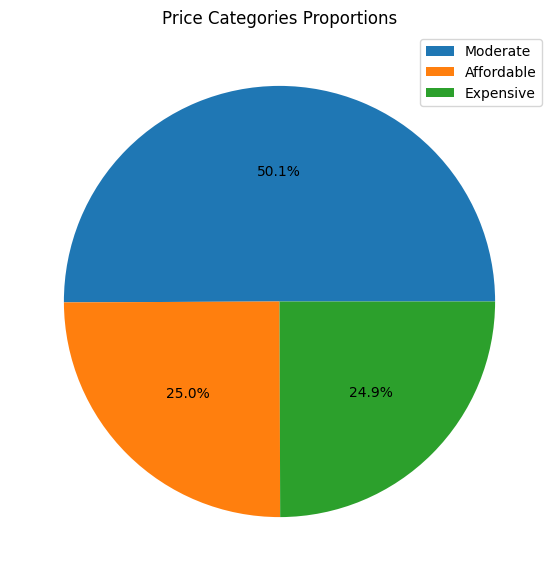

In [60]:
# plotting categories proportions
plt.figure(figsize=(15,7))
plt.pie(rent_df["price_cat"].value_counts(), autopct='%1.1f%%')
plt.legend(rent_df["price_cat"].value_counts().index)
plt.title("Price Categories Proportions");

### Stratified Random Sampling :

In [61]:
# getting data information
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83332 entries, 21 to 99825
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    83332 non-null  float64
 1   bedrooms     83332 non-null  float64
 2   fee          83332 non-null  int64  
 3   has_photo    83332 non-null  int64  
 4   price        83332 non-null  float64
 5   square_feet  83332 non-null  float64
 6   cityname     83332 non-null  int64  
 7   state        83332 non-null  int64  
 8   latitude     83332 non-null  float64
 9   longitude    83332 non-null  float64
 10  price_cat    83332 non-null  object 
dtypes: float64(6), int64(4), object(1)
memory usage: 7.6+ MB


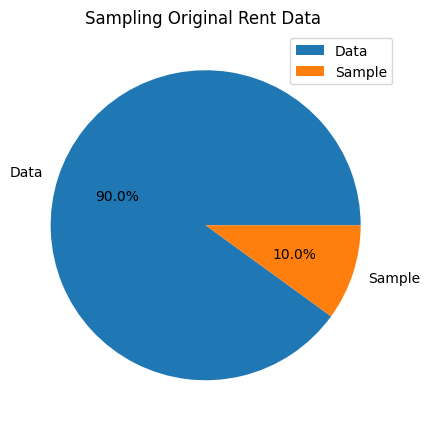

In [62]:
#plotting our sample size
plt.figure(figsize=(5,15))
data = [rent_df.shape[0]*0.9, rent_df.shape[0]*0.1]
labels = ['Data', 'Sample']
explode = (0, 0.2)
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title("Sampling Original Rent Data ")
plt.legend();

In [63]:
# getting our sample data using the categogrical "price" feature (1%)
sampled_data = stratified_sampling(rent_df,"price_cat",0.1)

In [64]:
# checking if the data is still balenced
sampled_data["price_cat"].value_counts()

price_cat
Moderate      4172
Affordable    2082
Expensive     2079
Name: count, dtype: int64

In [65]:
# plotting sample size
sampled_data.shape

(8333, 11)

In [66]:
# dropping target variable
data = sampled_data.drop(columns=["price_cat"])

# K-means :
Here we're goung to use the elbow method to investigate the optimal number of clusters for our k-means model where we will get k , then we apply clustering and investigated the results where through scatter plots

### Optimising `n_clusters` Using Elbow Method :

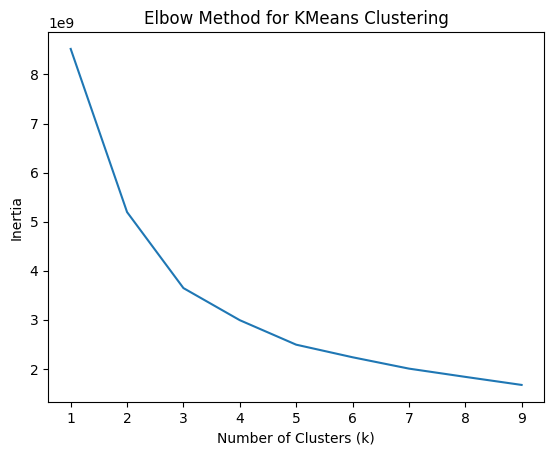

In [67]:
# Defining a range of k values to explore
k_range = range(1, 10)

# Initializing an empty list to store inertia values
inertias = []

# Looping through the k values
for k in k_range:
  # Creating a KMeans object with the current k value
  kmeans = KMeans(n_clusters=k)

  # Fitting the model to the data
  kmeans.fit(data)

  # Calculating inertia (sum of squared distances to centroids)
  inertia = kmeans.inertia_

  # Appending inertia to the list
  inertias.append(inertia)

# Plotting the k values vs inertia
import matplotlib.pyplot as plt

plt.plot(k_range, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

### Testing K-Means Clustering :

In [68]:
# trying data on a smaller data (only 4 features)
my_data = stratified_sampling(old_data,"price",0.1)
data = my_data[["price","square_feet","bathrooms","bedrooms"]]

In [69]:
k_means = KMeans(n_clusters=3, random_state=101)
k_means.fit_predict(data)
labels = k_means.labels_
centroids = k_means.cluster_centers_

In [70]:
data

,price,square_feet,bathrooms,bedrooms
0,350.0,600.0,1.0,2.0
1,375.0,500.0,1.0,1.0
2,400.0,670.0,1.0,1.0
3,400.0,377.0,1.0,1.0
4,425.0,625.0,1.0,1.0
...,...,...,...,...
8204,2932.0,1241.0,2.0,2.0
8205,2932.0,1690.0,2.0,3.0
8206,2932.0,1096.0,2.0,2.0
8207,2932.0,1337.0,2.0,2.0


### Plotting K-Means Results

In [71]:
# getting the different clusters
data['cluster'] = k_means.labels_
df1 = data[data['cluster'] == 0]
df2 = data[data['cluster'] == 1]
df3 = data[data['cluster'] == 2]

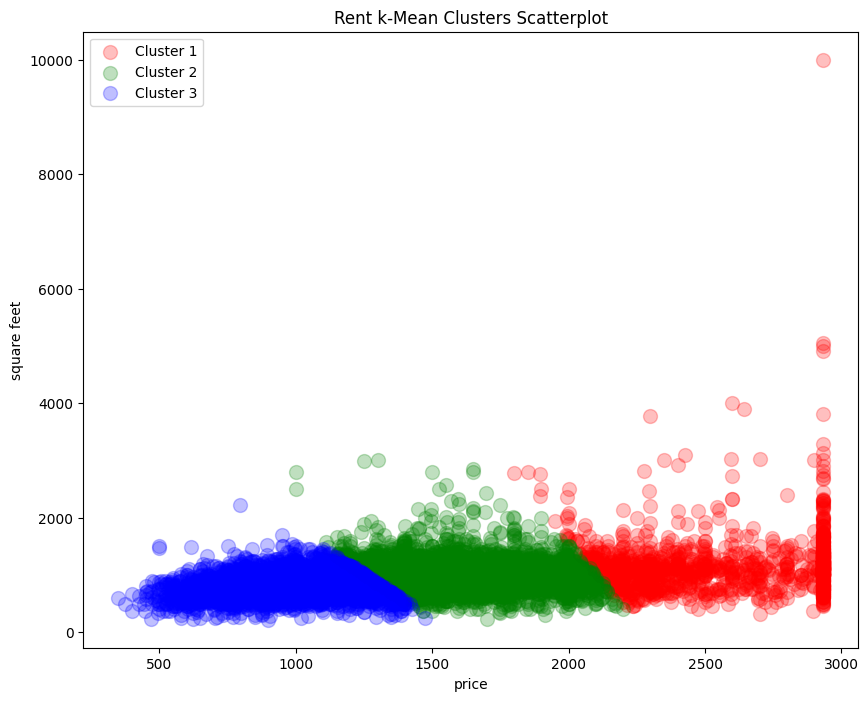

In [72]:
# plotting our rent clusters
plt.figure(figsize=(10, 8), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel("price")
plt.ylabel("square feet")

plt.scatter(df1.price, df1.square_feet, alpha = 0.25, s = 100, color='red',label="Cluster 1")
plt.scatter(df2.price, df2.square_feet, alpha = 0.25, s = 100, color='green',label="Cluster 2")
plt.scatter(df3.price, df3.square_feet, alpha = 0.25, s = 100, color='blue',label="Cluster 3")
plt.legend()
plt.title("Rent k-Mean Clusters Scatterplot");

# Anomaly Detection
During preprocessing, we removed outliers.This might seem counter-intuitive for anomaly detection, but our goal was to identify genuine anomalies, not simply large values that deviate from the average. To achieve this, we employed a distance-based approach using KNN with a maximum of 4 neighbors

## Getting Data :

In [73]:
# trying the same sample For Anomaly detection
my_data = stratified_sampling(old_data,"price",0.1)
data = my_data[["price","square_feet","bathrooms","bedrooms"]]

In [74]:
# investigating data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8209 entries, 0 to 8208
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        8209 non-null   float64
 1   square_feet  8209 non-null   float64
 2   bathrooms    8209 non-null   float64
 3   bedrooms     8209 non-null   float64
dtypes: float64(4)
memory usage: 256.7 KB


## Distance Based Anomaly Detection :

In [75]:
# getting anomaly score using KNN
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(data.values)
distances, indices = nbrs.kneighbors(data.values)
anomaly_score = distances[:,knn-1]

In [76]:
# Appending Anomaly Score into a dataframe
anom = pd.DataFrame(anomaly_score, index=data.index, columns=['Anomaly_score'])
result = pd.concat((data,anom), axis=1)
result.nlargest(5,'Anomaly_score')

,price,square_feet,bathrooms,bedrooms,Anomaly_score
8008,2932.0,9998.0,1.0,0.0,5087.004914
8101,2932.0,5055.0,9.0,6.0,1106.017631
7929,2932.0,4996.0,5.0,4.0,1049.877136
7917,2932.0,4911.0,6.0,5.0,969.612809
7356,2300.0,3770.0,4.0,5.0,633.975552


## Plotting Anomaly Results :

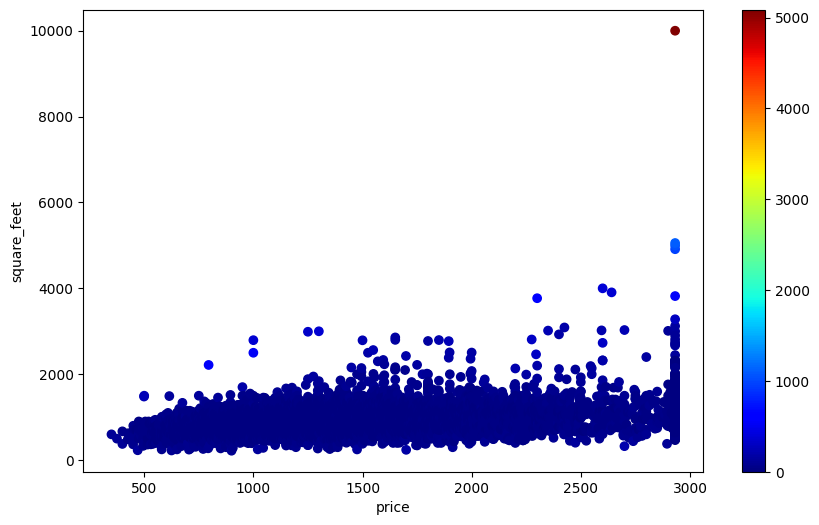

In [77]:
# plotting anomaly score for "price" vs. "square_feet"
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(data.price,data.square_feet,c=anomaly_score,cmap='jet')
ax.set_xlabel('price')
ax.set_ylabel('square_feet')
fig.colorbar(p);

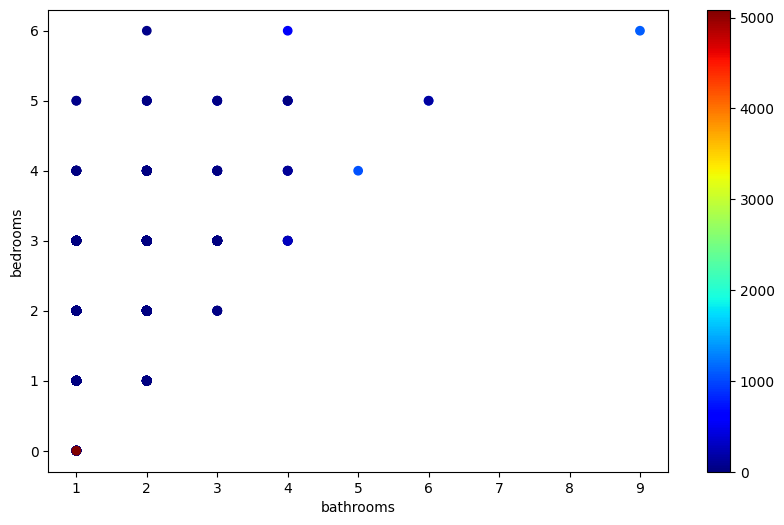

In [78]:
# plotting anomaly score for "bathrooms" vs. "bedrooms"
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(data.bathrooms,data.bedrooms,c=anomaly_score,cmap='jet')
ax.set_xlabel('bathrooms')
ax.set_ylabel('bedrooms')
fig.colorbar(p);

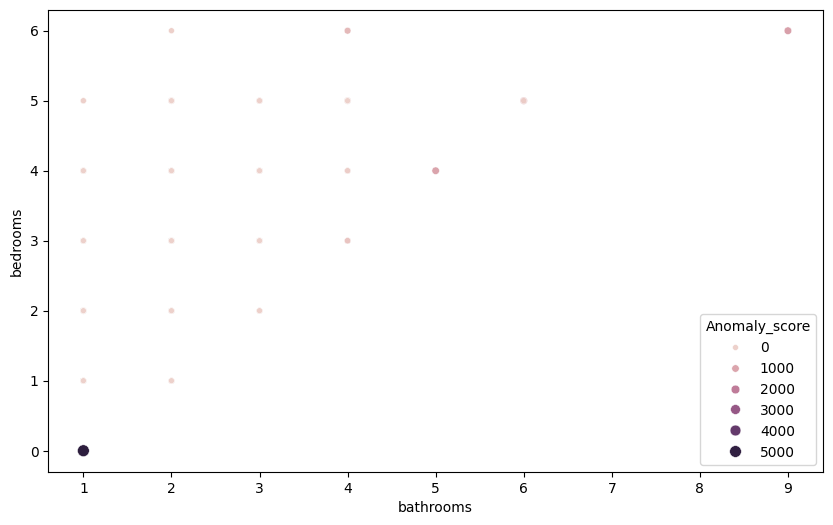

In [79]:
# plotting the anomaly score with data count for "bathrooms" vs. "bedrooms"
fig = plt.figure(figsize=(10,6))
sns.scatterplot(data=result, x="bathrooms", y="bedrooms", size="Anomaly_score",hue="Anomaly_score");